# Grapheme-to-Phoneme with CTC

This notebook uses Connectionist Temporal Classification on top of a character-level bidirectional language model.

In [1]:
import regex as re

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
# Choose whether to use GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

## Load train set

In [4]:
# Load Wiktionary train set
df = pd.read_csv("../scratch/train.tsv", sep="\t", na_filter=False, encoding="utf-8")
df.head()

text      pronunciation
0           anatines           a.na.tin
1  omniscientisasses  ɔm.ni.sjɑ̃.ti.zas
2        re-répétera     ʁə.ʁe.pɛ.tə.ʁa
3      recaracoleras  ʁə.ka.ʁa.kɔ.lə.ʁa
4   désinformeraient   de.zɛ̃.fɔʁ.mə.ʁɛ

In [5]:
# Use lowercase text
df["text"] = df["text"].str.lower()

# Discard syllable information
df["pronunciation"] = df["pronunciation"].str.replace(".", "").str.replace("‿", " ")

In [6]:
# Compute length ratio
df["ratio"] = df["text"].apply(len) / df["pronunciation"].apply(len)

# Discard small ratio (typically abbreviations) and large ratios (often incomplete IPA)
df = df[(df["ratio"] > 0.8) & (df["ratio"] < 4.0)]

In [7]:
# Count how many space and symbols are in the text
def num_special(t):
    return sum(not c.isalnum() for c in t)

# Apply to dataset
special_counts = df["text"].apply(num_special)
special_counts.value_counts()

0     109501
1      26019
2      13706
3       3905
4       1405
5        575
6        251
7        149
8         72
9         43
10        19
11        18
12         8
13         5
14         3
15         3
23         1
17         1
18         1
19         1
31         1
Name: text, dtype: int64

In [8]:
# We sub-sample to avoid too many "naive" single-word expressions
mask = special_counts > 2
complex_df = df[mask]
simple_df = df[~mask].sample(frac=0.1)
df = pd.concat([simple_df, complex_df])

In [9]:
# TODO add custom datasets here

## Define vocabularies

In [10]:
# Character set, identical to the one used in language model
GRAPHEMES = ["<PAD>"] + list(" !'\"(),-.:;?abcdefghijklmnopqrstuvwxyzàâäçèéêëîïôöùûü")
GRAPHEME_MAP = {c: i for i, c in enumerate(GRAPHEMES)}

In [11]:
# IPA symbols used in French
PHONEMES = [
    "<PAD>",
    " ", "a", "b", "d", "e", "f", "i", "j",
    "k", "l", "m", "n", "o", "p", "s", "t",
    "u", "v", "w", "y", "z", "ø", "ŋ", "œ",
    "œ̃", "ɑ", "ɑ̃", "ɔ", "ɔ̃", "ə", "ɛ", "ɛ̃",
    "ɡ", "ɥ", "ɲ", "ʁ", "ʃ", "ʒ",
]
PHONEME_MAP = {c: i for i, c in enumerate(PHONEMES)}

In [33]:
def graphemes_to_indices(text):
    tensor = torch.zeros(len(text) + 2, dtype=torch.long)
    for i, c in enumerate(text):
        tensor[i + 1] = GRAPHEME_MAP[c]
    return tensor

In [34]:
def phonemes_to_indices(pronunciation):
    match = re.fullmatch(r"(.\u0303?)*", pronunciation)
    symbols = match.captures(1)
    tensor = torch.zeros(len(symbols) + 2, dtype=torch.long)
    for i, c in enumerate(symbols):
        tensor[i + 1] = PHONEME_MAP[c]
    return tensor

In [35]:
def indices_to_phoneme(indices):
    return "".join(PHONEMES[i] for i in indices if i != 0)

## Preprocess dataset

In [14]:
# Define language model
class LanguageModel(nn.Module):
    def __init__(self, num_symbols, embedding_size, hidden_size):
        super().__init__()
        
        # Store parameters
        self.num_symbols = num_symbols
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        # Symbols are embedded
        self.embedding = nn.Embedding(
            num_embeddings=num_symbols,
            embedding_dim=embedding_size,
            padding_idx=0,
        )
        
        # Using bidirectional GRU, each direction being one language model
        self.rnn = nn.GRU(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
        )
        
        # Use simple classification layer, for both direction
        self.forward_classifier = nn.Linear(hidden_size, num_symbols)
        self.backward_classifier = nn.Linear(hidden_size, num_symbols)
    
    def encode(self, sequences, lengths):
        
        # First, embed symbols
        embedded_sequences = self.embedding(sequences)
        
        # For efficiency (i.e. avoid encoding padding), use packed sequence object
        packed_embedded_sequences = nn.utils.rnn.pack_padded_sequence(
            input=embedded_sequences,
            lengths=lengths,
            enforce_sorted=False,
        )
        
        # Apply RNN, discard state
        packed_encoded_sequences, _ = self.rnn(packed_embedded_sequences)
        
        # Unpack sequences to original lengths
        encoded_sequences, _ = nn.utils.rnn.pad_packed_sequence(
            sequence=packed_encoded_sequences,
            total_length=sequences.shape[0],
        )
        
        return encoded_sequences
    
    # ... omitted for brevity ...

In [16]:
# Load trained LM
lm = LanguageModel(
    num_symbols=len(GRAPHEMES),
    embedding_size=32,
    hidden_size=128,
)
lm.load_state_dict(torch.load("lm.pt"))

# Move to GPU, if requested
if use_cuda:
    lm.cuda()

In [17]:
# Prepare dataset
dataset = []
for i in tqdm(range(len(df))):
    
    # Get sample
    text = df["text"].iloc[i]
    pronunciation = df["pronunciation"].iloc[i]
    
    # Encode text
    with torch.no_grad():
        sequences = graphemes_to_indices(text).unsqueeze(1)
        lengths = torch.tensor(sequences.shape[0], dtype=torch.long).unsqueeze(0)
        if use_cuda:
            sequences = sequences.cuda()
            lengths = lengths.cuda()
        features = lm.encode(sequences, lengths).squeeze(1).cpu()
    
    # Encode pronunciation
    phonemes = phonemes_to_indices(pronunciation)
    
    # Store pair
    sample = features, phonemes
    dataset.append(sample)

100%|███████████████████████████████████████████████████████████████████████████| 21384/21384 [01:33<00:00, 228.44it/s]


In [18]:
# Save, for later
torch.save(dataset, "preprocessed.bin")

In [19]:
# Reload
dataset = torch.load("preprocessed.bin")

## Create data loader

In [20]:
# Need special collate function to handle variable-length data
def collate(batch):
    inputs, outputs = zip(*batch)
    
    input_sequences = nn.utils.rnn.pad_sequence(inputs)
    output_sequences = nn.utils.rnn.pad_sequence(outputs)
    
    input_lengths = torch.tensor([len(i) for i in inputs], dtype=torch.long)
    output_lengths = torch.tensor([len(o) for o in outputs], dtype=torch.long)
    
    return input_sequences, input_lengths, output_sequences, output_lengths

# Wrap dataset into loader
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate,
    pin_memory=use_cuda,
)

## Define model

In [28]:
class Model(nn.Module):
    def __init__(self, num_input_features, hidden_size, num_output_symbols):
        super().__init__()
        
        # Store parameters
        self.num_input_features = num_input_features
        self.hidden_size = hidden_size
        self.num_output_symbols = num_output_symbols
        
        # We will use a combination of regular convolutions and transposed convolutions
        # Note that we need some expansion, as CTC assumes that output lengths are smaller than input lengths
        self.c1 = nn.ConvTranspose1d(num_input_features, hidden_size, kernel_size=3, stride=3)
        self.c2 = nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=3, padding=1)
        self.c3 = nn.Conv1d(hidden_size * 2, num_output_symbols, kernel_size=1)
    
    def forward(self, input_sequences, input_lengths):
        
        # Need to transpose, as
        #   rnn are length x batch_size x features
        #   convolution are batch_size x features x length
        tmp = input_sequences.permute(1, 2, 0)
        
        # Apply convolutions
        tmp = F.leaky_relu(self.c1(tmp))
        tmp = F.leaky_relu(self.c2(tmp))
        tmp = self.c3(tmp)
        
        # Restore dimension order
        output_sequences = tmp.permute(2, 0, 1)
        
        # Compute new length (hard-coded, depends on our convolutions)
        output_lengths = input_lengths * 3
        
        return output_sequences, output_lengths

## Do training

In [55]:
# Instanciate model
model = Model(
    num_input_features=lm.hidden_size*2, # 256
    hidden_size=128,
    num_output_symbols=len(PHONEMES),
)
if use_cuda:
    model.cuda()

# Instanciate optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [56]:
# Train loop
num_epochs = 20
losses = []
for epoch in range(num_epochs):
    for input_sequences, input_lengths, output_sequences, output_lengths in tqdm(loader):
        if use_cuda:
            input_sequences = input_sequences.cuda()
            input_lengths = input_lengths.cuda()
            output_sequences = output_sequences.cuda()
            output_lengths = output_lengths.cuda()
        
        # Apply model
        logits, lengths = model(input_sequences, input_lengths)
        log_probs = F.log_softmax(logits, dim=2)
        
        # Compute CTC loss
        loss = F.ctc_loss(
            log_probs=log_probs,
            targets=output_sequences.transpose(1, 0),
            input_lengths=lengths,
            target_lengths=output_lengths,
            zero_infinity=True,
        )
        loss_value = loss.item()
        assert not np.isnan(loss_value)
        losses.append(loss_value)
        
        # Back-propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [00:03<00:00, 90.37it/s]


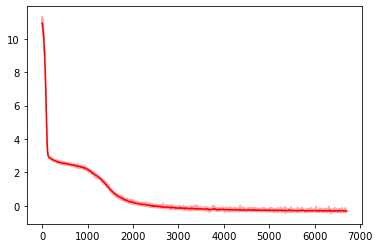

In [57]:
# Plot training loss
fig, ax = plt.subplots()

y = np.array(losses)
x = np.arange(y.shape[0])
y_smooth = gaussian_filter1d(y, 5, mode="nearest")

ax.plot(x, y, c="#ffaaaa")
ax.plot(x, y_smooth, "r")

plt.show()

In [58]:
# Save trained model for later
model.cpu()
torch.save(model.state_dict(), "phoneme.pt")

In [59]:
# Switch to evaluation mode
model.eval()

Model(
  (c1): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(3,))
  (c2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (c3): Conv1d(256, 39, kernel_size=(1,), stride=(1,))
)

## Apply to unseen input

In [60]:
lm.cpu()

LanguageModel(
  (embedding): Embedding(54, 32, padding_idx=0)
  (rnn): GRU(32, 128, bidirectional=True)
  (forward_classifier): Linear(in_features=128, out_features=54, bias=True)
  (backward_classifier): Linear(in_features=128, out_features=54, bias=True)
)

In [61]:
def translate(text):
    with torch.no_grad():

        # Encode graphemes
        sequences = graphemes_to_indices(text).unsqueeze(1)
        lengths = torch.tensor(sequences.shape[0], dtype=torch.long).unsqueeze(0)
        features = lm.encode(sequences, lengths)

        # Apply model
        logits, output_lengths = model(features, lengths)

        # Extract the raw indices (i.e. best path decoding)
        indices = logits.argmax(dim=2)
        length = output_lengths[0]
        indices = indices[:length, 0].tolist()

        # Deduplicate indices, as per CTC scheme
        output = []
        previous = None
        for index in indices:
            if index != previous:
                previous = index
                if index > 0:
                    output.append(index)

        # Convert back to IPA
        pronunciation = indices_to_phoneme(output)
        return pronunciation

In [62]:
translate("terrible")

'tɛʁibl'

In [63]:
translate("anticonstitutionnellement")

'ɑ̃tikɔ̃stitysjɔnɛjmɑ̃'

In [64]:
translate("un chat")

'œ̃ ʃa'

In [65]:
translate("l'arbre qui cache la forêt")

'l aʁbʁ ki kaʃ la fɔʁɛ'

In [66]:
translate("les poules du couvent couvent le matin")

'le pul dy kuvɑ̃ kuvɑ̃ lə matɛ̃'